In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt
import matplotlib.pyplot as plt
import optuna, os
from time import time
from datetime import datetime

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
STRATIFIED_SPLIT = False

### Load Dataset

In [3]:
#DF_PATH = "data/lifestyle_sustainability_data_standardized.csv"
DF_PATH = "data/lifestyle_sustainability_data_standardized_res_smote.csv"

In [4]:
df_raw = pd.read_csv(DF_PATH)
print(df_raw.shape)
print(df_raw.columns)
print(df_raw.dtypes)
df_raw.head()

(880, 13)
Index(['EnvironmentalAwareness', 'CommunityInvolvement',
       'MonthlyElectricityConsumption', 'MonthlyWaterConsumption',
       'PhysicalActivities', 'DietType_Balanced',
       'DietType_Mostly Animal-Based', 'DietType_Mostly Plant-Based',
       'TransportationMode_Bike', 'TransportationMode_Car',
       'TransportationMode_Public Transit', 'TransportationMode_Walk',
       'Rating'],
      dtype='object')
EnvironmentalAwareness               float64
CommunityInvolvement                 float64
MonthlyElectricityConsumption        float64
MonthlyWaterConsumption              float64
PhysicalActivities                   float64
DietType_Balanced                    float64
DietType_Mostly Animal-Based         float64
DietType_Mostly Plant-Based          float64
TransportationMode_Bike              float64
TransportationMode_Car               float64
TransportationMode_Public Transit    float64
TransportationMode_Walk              float64
Rating                             

,EnvironmentalAwareness,CommunityInvolvement,MonthlyElectricityConsumption,MonthlyWaterConsumption,PhysicalActivities,DietType_Balanced,DietType_Mostly Animal-Based,DietType_Mostly Plant-Based,TransportationMode_Bike,TransportationMode_Car,TransportationMode_Public Transit,TransportationMode_Walk,Rating
0,1.445313,1.385178,-1.594895,-1.340155,1.347737,-0.680693,-0.636894,1.238142,1.786974,-0.624477,-0.571951,-0.553428,5
1,0.699490,-0.034132,-0.348649,-0.114045,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,4
2,-0.792157,-1.453442,0.897597,1.112064,-1.472057,-0.680693,1.570120,-0.807662,-0.559605,1.601339,-0.571951,-0.553428,1
3,0.699490,-0.034132,-1.179480,-0.931452,1.347737,-0.680693,-0.636894,1.238142,-0.559605,-0.624477,-0.571951,1.806919,5
4,-0.046334,-1.453442,0.066766,0.294658,-0.062160,1.469091,-0.636894,-0.807662,-0.559605,-0.624477,1.748402,-0.553428,3


In [5]:
df_raw.groupby("Rating").size()

Rating
1    176
2    176
3    176
4    176
5    176
dtype: int64

#### Prepare X and Y

In [6]:
RANDOM_STATE = 42
test_size = 0.05 # test set
val_size = 0.1 # validation set

In [7]:
df = df_raw.copy()
df.shape

(880, 13)

In [8]:
df["Rating"] = df["Rating"].apply(lambda rating: rating - 1) # required to fit XGBoost
target_column = df.pop("Rating")
X = df.to_numpy()
Y = np.array(target_column.to_list())
X.shape, Y.shape

((880, 12), (880,))

Train/Test Split

In [9]:
if STRATIFIED_SPLIT:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, stratify=Y, random_state=RANDOM_STATE) # stratified train/test
else:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=RANDOM_STATE)

print(f"X_train: {X_train.shape} | Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape} | Y_test: {Y_test.shape}")
print(f"Y_test label distribution: {np.unique(Y_test, return_counts=True)}")

X_train: (836, 12) | Y_train: (836,)
X_test: (44, 12) | Y_test: (44,)
Y_test label distribution: (array([0, 1, 2, 3, 4]), array([11,  9, 10,  6,  8], dtype=int64))


---

In [10]:
number_of_splits = 5

if STRATIFIED_SPLIT:
    shufflesplit = StratifiedShuffleSplit(n_splits=number_of_splits, test_size=val_size, random_state=RANDOM_STATE)
else:
    shufflesplit = ShuffleSplit(n_splits=number_of_splits, test_size=val_size, random_state=RANDOM_STATE)

shufflesplit

ShuffleSplit(n_splits=5, random_state=42, test_size=0.1, train_size=None)

In [11]:
score_metric = "roc_auc_ovo" # ROC-AUC One-vs-One Approach

### Objective Functions

In [12]:
# Random Forest

def objective_rf(trial: optuna.Trial):
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 150, log=True)
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 6, log=True)
    rf_max_features = trial.suggest_int("rf_max_features", 2, X.shape[1], log=True)
    classifier_obj = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth, max_features=rf_max_features)
    score = cross_val_score(estimator=classifier_obj, X=X_train, y=Y_train, scoring=score_metric, n_jobs=-1, cv=shufflesplit)
    roc_auc_ovo = score.max()
    return roc_auc_ovo

In [13]:
# XGBoost

def objective_xgb(trial= optuna.Trial):
    xgb_gamma = trial.suggest_float("xgb_gamma", 0, 0.5, step=0.01)
    xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.5, step=0.01)
    xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 6, log=True)
    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 50, 150, log=True)
    classifier_obj = xgb.XGBClassifier(objective='multi:softprob', gamma=xgb_gamma, learning_rate=xgb_learning_rate, 
                                       max_depth=xgb_max_depth, n_estimators=xgb_n_estimators) # XGBClassifier for multi-class classification
    score = cross_val_score(estimator=classifier_obj, X=X_train, y=Y_train, scoring=score_metric, n_jobs=-1, cv=shufflesplit)
    roc_auc_ovo = score.max()
    return roc_auc_ovo

In [14]:
# MLPClassifier

def objective_mlpc(trial= optuna.Trial):
    mlpc_first_layer_neurons = trial.suggest_int("mlpc_first_layer_neurons", 10, 100, step=10)
    mlpc_second_layer_neurons = trial.suggest_int("mlpc_second_layer_neurons", 10, 100, step=10)
    mlpc_activation =  trial.suggest_categorical("mlpc_activation", ["tanh", "relu"])
    mlpc_batch_size = trial.suggest_int("mlpc_batch_size", 50, 300, step=50)
    mlpc_learning_rate = trial.suggest_categorical("mlpc_learning_rate", ["constant", "invscaling", "adaptive"])
    mlpc_max_iter = trial.suggest_int("mlpc_max_iter", 100, 500, step=100)
    
    # Regularization params
    mlpc_alpha = trial.suggest_float("mlpc_alpha", 0.0001, 0.2, step=0.0001) # L2 Norm
    mlpc_early_stopping = trial.suggest_categorical("mlpc_early_stopping", [False, True]) # Early Stopping strategy
    mlpc_tol = trial.suggest_float("mlpc_tol", 0.0001, 0.1, step=0.0001) # Tolerance for early stopping
    mlpc_n_iter_no_change = trial.suggest_int("mlpc_n_iter_no_change", 5, 20, step=5) # Maximum number of epochs to not meet tol improvement.

    classifier_obj = MLPClassifier(hidden_layer_sizes=(mlpc_first_layer_neurons, mlpc_second_layer_neurons),
                                   activation=mlpc_activation, batch_size=mlpc_batch_size, learning_rate=mlpc_learning_rate, 
                                   max_iter=mlpc_max_iter, alpha=mlpc_alpha, early_stopping=mlpc_early_stopping, 
                                   tol=mlpc_tol, n_iter_no_change=mlpc_n_iter_no_change)

    score = cross_val_score(estimator=classifier_obj, X=X_train, y=Y_train, scoring=score_metric, n_jobs=-1, cv=shufflesplit)
    roc_auc_ovo = score.max()
    return roc_auc_ovo

In [15]:
# Logistic Regression

def objective_lr(trial= optuna.Trial):
    lr_max_iter = trial.suggest_int("lr_max_iter", 100, 500, step=100)

    # Regularization params
    lr_penalty = trial.suggest_categorical("lr_penalty", ["l1", "l2", "elasticnet", None]) # Norm of the penalty
    lr_tol = trial.suggest_float("lr_tol", 0.0001, 0.1, step=0.0001) # Convergence threshold
    lr_c = trial.suggest_float("lr_c", 0.001, 2.0, step=0.001) # Inverse of regularization strength
    lr_l1_ratio = trial.suggest_float("lr_l1_ratio", 0.0, 1.0, step=0.01)

    classifier_obj = OneVsOneClassifier(LogisticRegression(solver="saga", max_iter=lr_max_iter, penalty=lr_penalty, 
                                                           tol=lr_tol, C=lr_c, l1_ratio=lr_l1_ratio))

    score = cross_val_score(estimator=classifier_obj, X=X_train, y=Y_train, scoring=None, n_jobs=-1, cv=shufflesplit) # the estimator’s default scorer is used.
    roc_auc_ovo = score.max()
    return roc_auc_ovo

In [16]:
models = {
    "RF": objective_rf,
    "XGB": objective_xgb,
    "MLPC": objective_mlpc,
    "LR": objective_lr
}

In [17]:
def build_best_estimator(model: str, params: dict) -> object:
    estimator = None
    match model:
        case "RF": 
            estimator = RandomForestClassifier(n_estimators=params["rf_n_estimators"], max_depth=params["rf_max_depth"], 
                                               max_features=params["rf_max_features"])
        case "XGB":
            estimator = xgb.XGBClassifier(objective='multi:softprob', 
                                          gamma=params["xgb_gamma"], learning_rate=params["xgb_learning_rate"], 
                                          max_depth=params["xgb_max_depth"], n_estimators=params["xgb_n_estimators"])
        case "MLPC":
            estimator = MLPClassifier(hidden_layer_sizes=(params["mlpc_first_layer_neurons"], params["mlpc_second_layer_neurons"]), 
                                      activation=params["mlpc_activation"], batch_size=params["mlpc_batch_size"], learning_rate=params["mlpc_learning_rate"], 
                                      max_iter=params["mlpc_max_iter"], alpha=params["mlpc_alpha"], early_stopping=params["mlpc_early_stopping"], 
                                      tol=params["mlpc_tol"], n_iter_no_change=params["mlpc_n_iter_no_change"])
        case "LR":
            estimator = LogisticRegression(solver="saga", max_iter=params["lr_max_iter"], penalty=params["lr_penalty"], tol=params["lr_tol"], 
                                           C=params["lr_c"], l1_ratio=params["lr_l1_ratio"])
        case _: pass
    return estimator

#### Run Experiments

In [18]:
n_trials = 50
experiment_name = "Second-Experiment-SMOTE"
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [19]:
best_estimators = []
df_results = pd.DataFrame(columns=["model", "score_val", "params"])
timestamp = datetime.fromtimestamp(time()).strftime("%Y-%m-%d_%H-%M-%S")

for model, objective_function in models.items():
    study = optuna.create_study(storage="sqlite:///db.sqlite3", study_name=f"{experiment_name}_{model}_{timestamp}", direction="maximize")
    print(f"Fitting {model} ...")
    study.optimize(models[model], n_trials=n_trials, n_jobs=-1)

    print("Fitting best estimator...")
    best_estimator = build_best_estimator(model, study.best_params)
    best_estimator.fit(X_train, Y_train) # Refit best estimator on the whole (training) dataset.
    print("Completed!\n")
    
    best_estimators.append((model, best_estimator))
    df_results.loc[len(df_results)] = [model, round(study.best_value, 3), study.best_params]

Fitting RF ...
Fitting best estimator...
Completed!

Fitting XGB ...
Fitting best estimator...
Completed!

Fitting MLPC ...
Fitting best estimator...
Completed!

Fitting LR ...
Fitting best estimator...
Completed!



c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [20]:
df_results

,model,score_val,params
0,RF,0.973,"{'rf_n_estimators': 68, 'rf_max_depth': 6, 'rf..."
1,XGB,0.974,"{'xgb_gamma': 0.1, 'xgb_learning_rate': 0.37, ..."
2,MLPC,0.961,"{'mlpc_first_layer_neurons': 40, 'mlpc_second_..."
3,LR,0.738,"{'lr_max_iter': 300, 'lr_penalty': None, 'lr_t..."


In [21]:
results_folder = f"results/{experiment_name}_{timestamp}"
os.mkdir(results_folder)

In [22]:
df_results.to_excel(f"{results_folder}/df_results.xlsx", index=False)

#### Results on Test Split

c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\kevin\.conda\envs\h_ls_project_env\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is de

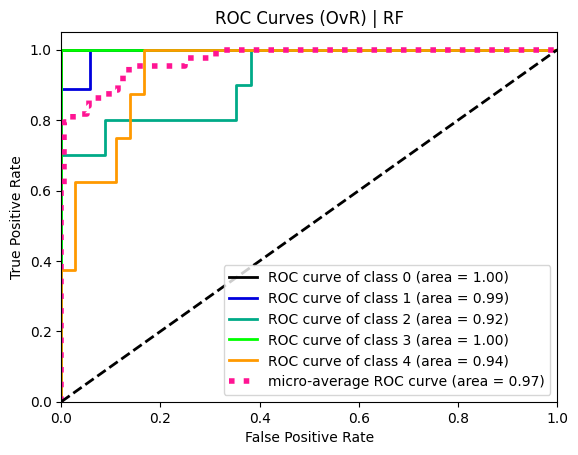

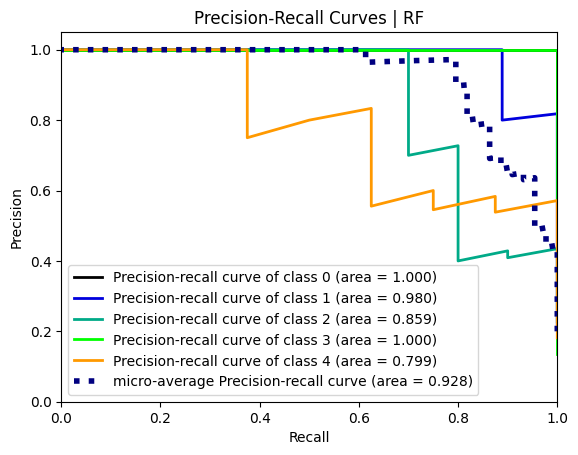

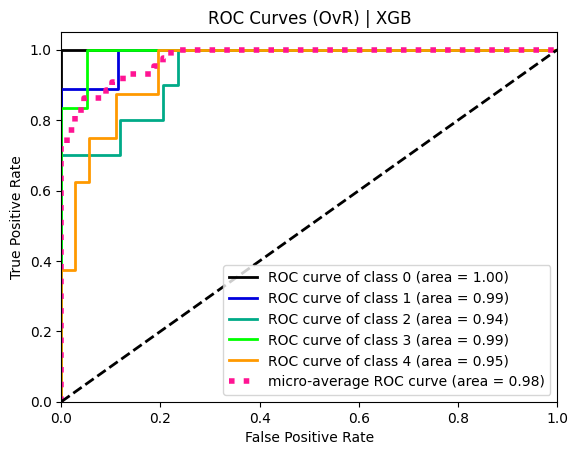

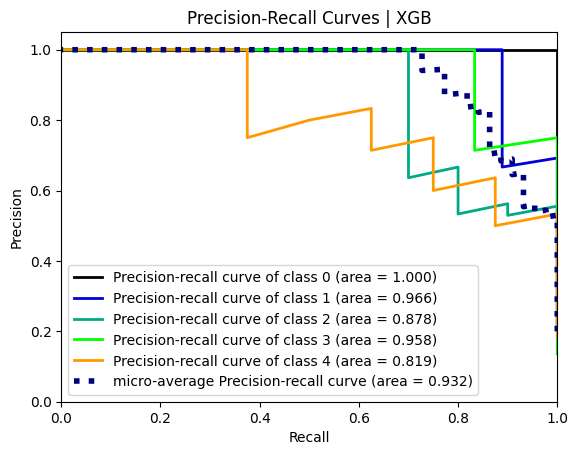

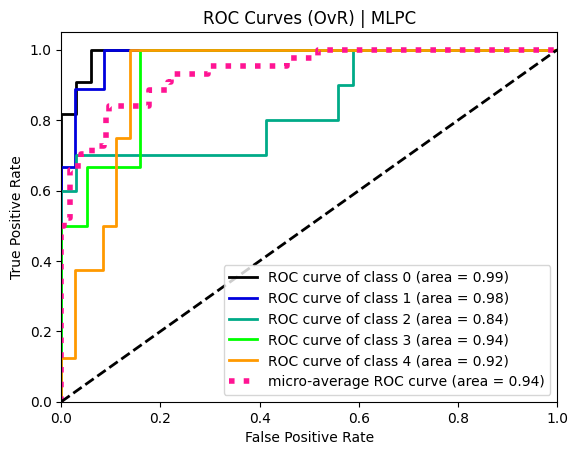

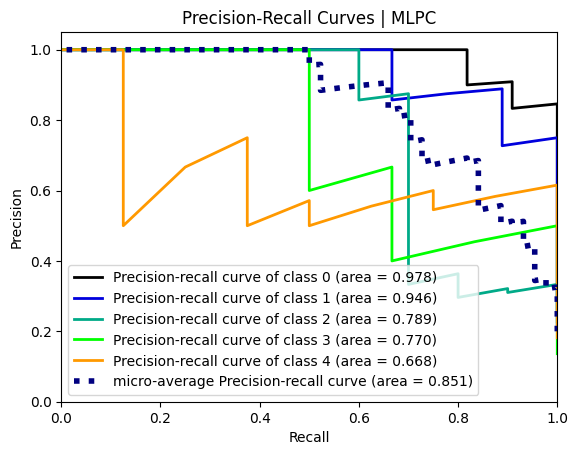

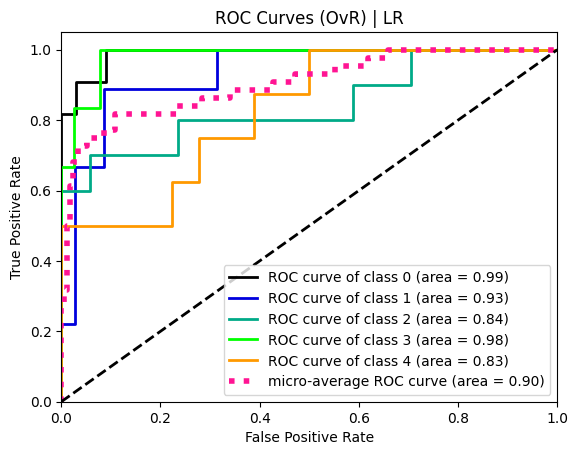

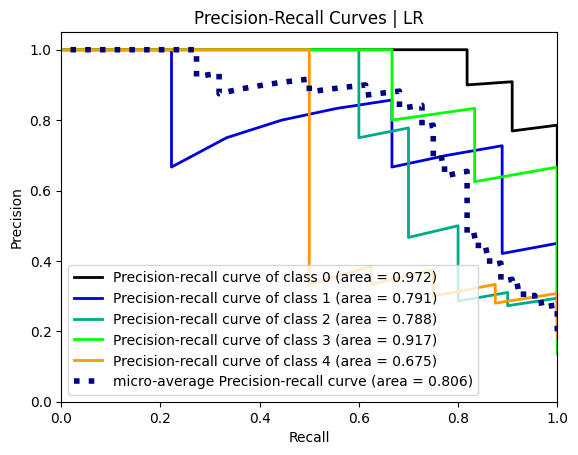

In [23]:
for estimator in best_estimators:
    model_name = estimator[0]
    estimator_obj = estimator[1]
    Y_test_predicted_proba_rf = estimator_obj.predict_proba(X_test)
    skplt.metrics.plot_roc_curve(Y_test, Y_test_predicted_proba_rf, title=f"ROC Curves (OvR) | {model_name}", curves=('micro', 'each_class')) # AUC-ROC OvR Approach
    plt.savefig(f"{results_folder}/{model_name}_roc_curve.png")
    skplt.metrics.plot_precision_recall_curve(Y_test, Y_test_predicted_proba_rf, title=f"Precision-Recall Curves | {model_name}")
    plt.savefig(f"{results_folder}/{model_name}_precision_recall_curve.png")